In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Table of contents
<a id='tof'></a>

#### Manuscript  
[Abstract](#Abstract)  
[Introduction](#Introduction)  
[The Virtual Seismologist in SeisComP3: VS(SC3)](#implementation)  
[Performance of VS(SC3) worldwide](#performance)  
[Discussion and Conclusion](#discussion)  
[Data and Resources](#resources)  
[Acknowledgements](#Acknowledgements)  
[References](#References)  
[Electronic Supplement](#supplement)  


#### Additional analysis
[Turkey](#Turkey)  
[Romania](#Romania)  
[Switzerland](#Switzerland)  
[Iceland](#Iceland)  
[New Zealand](#New-Zealand)  
[Greece](#Greece)  
[California](#California)

## Manuscript

### The Virtual Seismologist in SeisComP3: A New Implementation Strategy for Earthquake Early Warning Algorithms

by Yannik Behr, John F. Clinton, Carlo Cauzzi, Egill Hauksson, Kristín Jónsdóttir, Craiu G. Marius, Ali Pinar, Jerome Salichon, and Efthimios Sokos

#### Abstract
The feasibility of earthquake early warning (EEW) is now widely recognized. However, EEW systems that are in operation or under evaluation worldwide have significant variations and are usually operated independently of routine earthquake monitoring. We introduce a software that allows testing and evaluation of a well-known EEW algorithm directly within a widely used earthquake monitoring software platform. In the long term, we envision this approach can lead to (1) an easier transition from prototype to production type EEW implementations, (2) a natural and seamless evolution from very fast EEW source parameter estimates with typically large uncertainties to more delayed but more precise estimates using more traditional analysis methods, and (3) the capability of seismic networks to evaluate the readiness of their network for EEW, and to imple- ment EEW, without having to invest in and maintain separate, independent software systems. Using the Virtual Seismologist (VS), a popular EEW al-
gorithm that has been tested in real time in California since 2008, we demonstrate how our approach can be realized within the widely used monitoring platform SeisComP3. Because this software suite is already in production at many seismic networks worldwide,we have been able to test the new VS implementation across a wide variety of tectonic settings and network infrastructures. Using mainly real-time performance, we analyze over 3200 events with magnitudes between 2.0 and 6.8 and show that, for shallow crustal seismicity, 68% of the first VS magnitude estimates are within $\pm$ 0.5 magnitude units of the final reported magnitude. We further demonstrate the very significant effect of data communication strategies on final alert times. Using a Monte Carlo simulation approach, we then model the best possible alert times for optimally configured EEW systems and show that, for events within the dense parts of each of the seven test networks, effective warnings could be issued for magnitudes as small as M 5.0.

#### Introduction

Earthquake early warning (EEW) is the concept of using the early observations of seismic energy to predict expected ground-motion levels and provide warning before strong shaking arrives at the same or further-distant sites, often by first estimating event magnitude and location. In the case of distant sites, EEW relies on the fact that electromagnetic waves travel about $10^5$ times faster than the seismic waves that carry most of the seismic energy. Most EEW algorithms start providing EEW estimates following the detection of the P wave and thus can provide faster alerts (using the difference between P- and S-wave speeds) at the cost of higher estimate uncertainties. Some EEW systems first infer rupture parameters, such as hypocenter and rupture extent, and then predict ground-motion levels based on a regionally appropriate ground-motion prediction equation (GMPE) (e.g., Allen and Kanamori, 2003; Cua and Heaton, 2007; Satriano et al., 2008; Böse et al., 2009). Others directly compute expected peak ground motion, either empirically (e.g., Colombelli et al., 2015) or by using physical models of wavefield propagation (Hoshiba and Aoki, 2015). The basic principles of EEW were described by Cooper (1868) and Heaton (1985), but first operational implementations were not realized until 1988, when the Shinkansen, Japan’s high-speed train, was automatically slowed down by the UrEDAS system prior to strong shaking (Nakamura, 1988). Currently, several regions operate (e.g., Japan, Mexico, Taiwan, and Romania) or evaluate (e.g., China, Italy, Switzerland, Turkey, Greece, Iceland, several states in the United States, and the Canadian west coast) EEW systems (Espinosa-Aranda et al., 1995; Hoshiba et al., 2008; Cua et al., 2009; Mărmureanu et al., 2011; Peng et al., 2011; Böse et al., 2013; Zollo et al., 2013; Behr et al., 2015; Chen et al., 2015). 

EEW systems have been developing into multialgorithm
systems, using different strategies to estimate rupture parameters and peak ground motion, depending on the amount and type of data available (e.g., Global Positioning System [GPS] and seismic waveforms) during or immediately following a rupture. Japan is already operating such a multialgorithm system (Tamaribuchi et al., 2014), whereas this approach is being developed in California and Italy (Böse et al., 2013; Zollo et al., 2013).

The majority of EEW approaches provide rupture and shaking estimates that are initially very fast but uncertain, and they update continuously as more data arrive with increasing reliability. A natural extension of such an approach is to regard the entire earthquake monitoring as a progression from the fastest EEW alerts to the final detailed event analysis (with minimal uncertainties and at some minutes after the event origin time and long after strong shaking has passed) that can also include manual review and confirmation. Such end-to-end systems that combine EEW and traditional seismic network automatic analysis are, however, more complex and therefore more challenging to operate than an EEW system based on one algorithm only. Information from different approaches must be combined consistently, requiring additional logic as well as implementation standards to ensure different algorithms are compatible. There are significant benefits to this approach though; for example, station inventory needs to be only managed for a single software. Using the example of the Virtual Seismologist (VS) EEW algorithm (Cua, 2005; Cua and Heaton, 2007), we describe how such an end-to-end system that includes an EEW approach can be incorporated within a standard real-time earthquake monitoring platform, in this case SeisComP3 (SC3), which has become popular with seismic network operators worldwide (Hanka et al., 2010). We term this implementation VS(SC3), the implementation of VS in SC3. Although our VS implementation here is particular to SC3, similar EEW solutions could be integrated within other real-time monitoring platforms. 

Integrating EEW into routine earthquake monitoring systems further facilitates operating EEW algorithms in seismic networks that do not have dedicated EEW research groups. This is of increasing relevance, as seismic network densities and capabilities in many earthquake-prone regions are continuously improving in a way that may make EEW a routine feature of seismic networks within the next decades. Providing operators of these networks with EEW solutions that are configured and run the same way as other earthquake monitoring modules will significantly lower the additional effort required to provide EEW alerts. We show first results of running VS(SC3) in seven real-time seismic networks around the world and will outline further necessary algorithmic and infrastructural improvements to minimize alert delays in these regions.

#### The Virtual Seismologist in SeisComP3: VS(SC3)

<a id="implementation"></a>

SC3 is an open-source earthquake monitoring system (see Data and Resources) with professional software support (gempa GmbH; see Data and Resources). It follows a modular approach in which every module is a stand-alone program that communicates with other modules through a Transmission Control Protocol/Internet Protocol (TCP/IP) messaging sys- tem (Spread; see Data and Resources) and connects to a common database containing, among other information, the station metadata. 

VS was designed as a complete EEW solution, capable of including prior information in a Bayesian framework that estimates early warning magnitudes and epicentral locations (Cua, 2005). In practice, no prior component has been implemented, and the location information proved difficult to implement without significant numbers of false alarms when only few stations were used (Cua et al., 2009). For this reason, current implementations of VS only provide magnitude estimates and are triggered following independent external fast-event detection and location estimates. VS(SC3) implements the VS likelihood function as a separate module within SC3. In its original form, the VS likelihood function relates magnitude and epicenter to observed envelope values as follows:

$p(\mathbf{d}|M,lat,lon) = \frac{1}{2\pi^{D/2}} \frac{1}{|C|^{D/2}} exp\left\{ -\frac{1}{2} \left[\mathbf{d} - \mathbf{G}(M,lat,lon) \right] \mathbf{C}^{-1} \left[\mathbf{d} - \mathbf{G}(M,lat,lon) \right]\right \}$

in which $\mathbf{d}$ is the data vector containing five data values for every station with a P-wave detection. The first data value is the ratio between maximum envelope values of vertical acceleration (ZA) and vertical displacement (ZD). The second to fifth data values are maximum envelope values of vertical velocity (ZV) and root mean square horizontal acceleration (HA), velocity (HV), and displacement (HD) following a P- or S-wave arrival. With, for example, six stations reporting P-wave detec-
tions, $\mathbf{d}$ will thus be of length D=30. $\mathbf{G}$ is an empirical model, predicting the ratio of ZA and ZD (ZAD) as well as ZV, HA, HV, and HD at each station for P or S waves based on magnitude M and distance between an epicenter (latitude, longitude) and the station. It uses different sets of equations for P and S waves, and part of the VS algorithm is a P–S discriminant based on a weighted ratio between the products of ZA and ZV and HA and HV. \mathbf{C} is a D × D diagonal matrix of standard deviations for ZAD, ZV, HA, HV, and HD for every station
and phase, and $|\mathbf{C}|$ is its determinant. For the functional forms of $\mathbf{G}$ and the P–S discriminant, see Cua and Heaton (2007).

In the current implementation, VS(SC3) receives location estimates from SC3’s standard location module (scautoloc) and then reduces the original 3D likelihood function of magnitude, latitude, and longitude to a 1D likelihood function for magnitude only. It thereby replaces the original VS amplitude-based strong-motion centroid (Kanamori, 1993; Cua, 2005) with a location based on P-wave travel times, similar to the implementation used in the U.S. Geological Survey (USGS) ShakeAlert system (Cua et al., 2009). Scautoloc combines a grid search with the LocSAT inversion algorithm (Bratt and Bache, 1988). Detections of P-wave arrivals are provided by SC3’s scautopick module, which, by default, implements a short-term average/ long-termaverage (STA/LTA) picker (Allen, 1978) but can also apply secondary picking algorithms such as the Baer–Kradolfer picker (Baer and Kradolfer, 1987). 

Figure 1 shows a schematic description of the VS(SC3) modules and their information exchange within the SC3 environment. A preprocessing module (scenvelope) continuously computes a stream of envelope values over 1-s-long intervals after correcting the raw waveforms for gain and high-pass filtering at 0.33 Hz with a fourth-order Butterworth filter to reduce the influence of microseisms on the magnitude estimates of small events. Waveforms are also checked for saturation and are marked accordingly by comparing the raw counts with a percentage of the maximum possible number of raw counts on a 24-bit digitizer, as used by the vast majority of modern seismic networks. Another module (scvsmag) receives location estimates from scautoloc and combines this information with the continuously updating envelope values to compute the maximum, variance, and the expected value of the VS likelihood function for magnitude. Starting with the first location estimate, magnitude estimates are updated in 1 s intervals that take into account location updates and additional envelope values from all waveforms (not just the first few seconds following the P onset) and all stations with a P-wave detection as they become available. If waveforms from a broadband sensor have saturated, those of a collocated strong-motion sensor are used instead, if available. Ideally one would combine VS’ location estimates based on amplitudes and scautoloc’s location based on P-wave travel times; however, this requires the probability density function for both location estimates, which is currently only available for VS’ amplitude-based location estimates. We will discuss this further in the Discussion and Conclusion section.

The module scvsmaglog receives location and VS magnitude estimates and forwards them as a continuous stream of alerts to EEW-specific user interfaces, such as the UserDisplay (Böse et al., 2013; see Data and Resources) that is maintained and developed as part of the USGS ShakeAlert project or the Earthquake Early Warning Display (EEWD; see Data and Re- sources), which has been developed recently as an open-source derivative of the UserDisplay for European end users. Internally, scvsmaglog converts the SC3 data messages to either QuakeML (required by the EEWD) or ShakeAlert’s custom XML format (required by the UserDisplay) using extensible stylesheet language transformations (XSLTs) and then sends them to an ActiveMQ broker (see Data and Resources), which forwards the messages to subscribed end users. The use of XSLTs facilitates the addition of other alert message formats. Through SC3’s modular approach, several instances of scvsmaglog can be run that each receive the same input but send alert messages in different formats, thereby providing input for both the UserDisplay and the EEWD simultaneously. Scvsmaglog can further store alert histories on disk and send them by e-mail.

SC3’s messaging system facilitates the setup of systems distributed over several computing nodes that can be situated in different geographic locations. This can be particularly useful for situations in which several independent seismic networks without real-time data exchange are combined, as is, for example, the case in California. The modular approach allows running and testing of single modules independently from the whole monitoring infrastructure but also enables running different algorithms receiving the same input, easily replacing modules, and running multiple instances of the same algorithm with different configuration settings. As its data model, SC3 uses a derivative of QuakeML (see Data and Resources), which has become the standard for earthquake parameter exchange in recent years. This data model is used to store output from different modules in the central database, but it also enables an easy exchange with other systems capable of parsing QuakeML, such as the end-user EEWD. In SC3 real-time operations, waveforms are provided by one or more SEEDLink servers (Hanka et al., 2000); and, for subsequent analysis, the same waveforms can be requested through International Federation of Digital Seismograph Networks (FDSN) web services (see Data and Resources), or other SC3-specific data archives and distribution tools (e.g., ArcLink and SDSArchive). In addition to a suite of graphical monitoring tools, SC3 also provides a sophisticated graphical user interface (scolv) designed for routine earthquake monitoring, including manual event review and catalog management. Scolv can also be used to analyze the performance of VS(SC3). 

SC3 comes with an application programming interface (API) in C++ and Python that facilitates the use of the SC3 messaging system and provides access to the database and common math operations. Its most important feature, crucial to developing new modules related to EEW, is the generic access to waveform data independently from the actual waveform source, meaning waveforms can be replayed from archives or be accessed in real time. This ensures a seamless transition from offline testing of prototype implementations to operating them in real time.


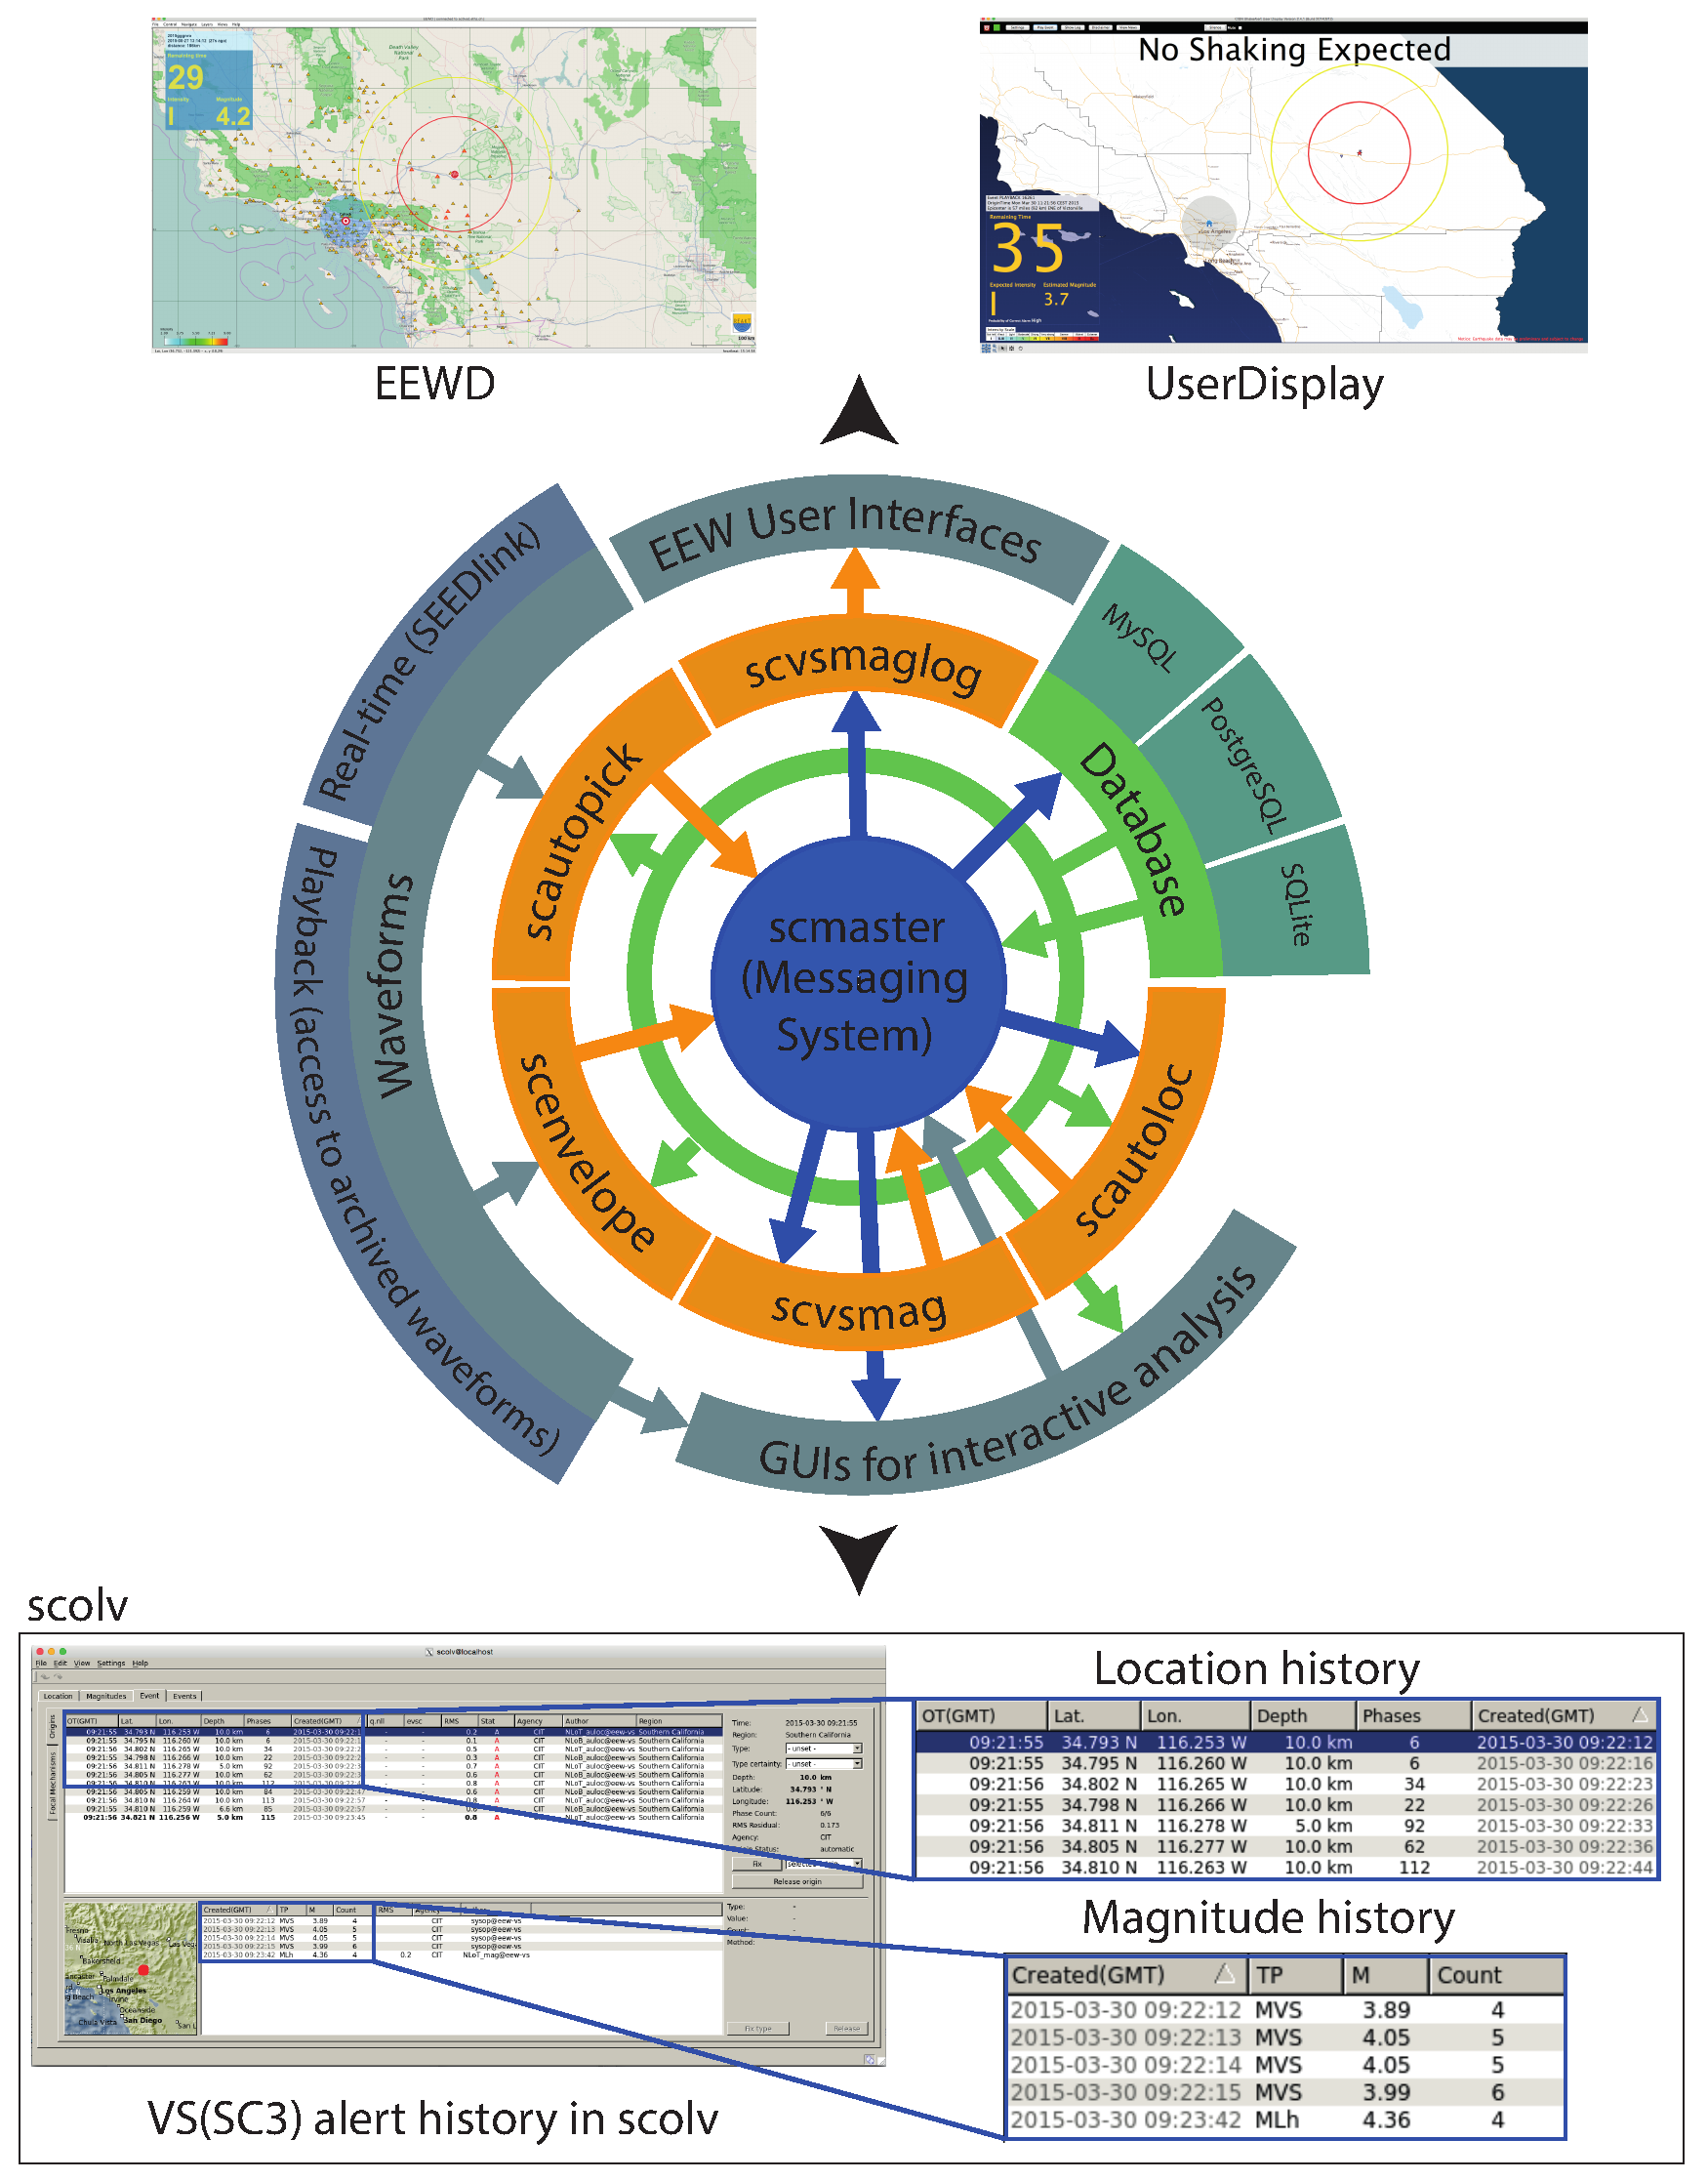

In [4]:
from IPython.display import Image
Image(filename='plots/VS_system_architecture_revised.png')

__Figure 1__. Processing flow of VS(SC3), the implementation of Virtual Seismologist in SeisComP3. Arrows indicate the direction of information flow, colored according to the sender. Together with the mediator (scmaster), the orange modules form the core of VS(SC3). Standard SC3 modules are used for P-wave detection and earthquake location (with scautopick as the autopicker and scautoloc as the locator). A VS-specific preprocessing module (scenvelope) provides a continuous stream of 1-s-envelope data for acceleration, velocity, and displacement; scenvelope accesses waveforms from various different sources through a common interface. Station and event meta-information can be stored in a relational database. Once an event is detected, real-time magnitudes are calculated and continuously updated by the VS(SC3) magnitude module (scvsmag). Real-time alerts are made available by the earthquake early warning (EEW) reporter (scvsmaglog) and can currently be received by two different EEW-specific end-user interfaces (UserDisplay and Earthquake Early Warning Display [EEWD]). Interactive analysis and review is done using scolv, a graphical user interface (GUI) that provides access to the database and to archived waveforms. The bottom panels show an example of only one of many analysis tools in scolv.

#### Performance of VS(SC3) worldwide

<a id="performance" ></a>

VS(SC3) was developed, tested, and first run routinely in Switzerland in 2013. It has subsequently been tested at six seismic networks worldwide — Greece, New Zealand, Romania, Turkey, Iceland, and southern California. Such broad implementation is possible thanks to the widespread distribution of SC3 and its ease of installation. Network operators already running SC3 for routine earthquake monitoring can therefore include VS(SC3) by simply updating their SC3 installation to a version containing the VS(SC3) modules. Configuration of the VS(SC3) modules is supported through extensive documentation, which is also embedded in SC3’s standard documentation (see Data and Resources). 

Seismicity within these seven networks differs strongly ranging from interplate and intraplate earthquakes at subduction zones (Greece and New Zealand), continental plate boundaries (California, New Zealand, Turkey, Greece, and Switzerland), and mid-ocean ridges (Iceland) to intermediate- depth subcrustal seismicity (Romania and Greece) and earthquakes related to volcanic activity (Iceland and New Zealand) (Anderson and Webb, 1994; Kastrup et al., 2004; Hauksson, 2010; Delavaud et al., 2012; Diehl et al., 2014). Including VS into SC3 has given us the unique opportunity to test an EEW algorithm in real time within these different tectonic settings with a wide range of source mechanisms, magnitudes, and hypocentral depths. All regions — highly built and industrialized — are exposed to moderate or high seismic hazard (Giardini et al., 1999, 2014; Stirling et al., 2012) and may therefore profit from an operational EEW system.

Further, each network varies in terms of network density and configuration with respect to relevant seismicity (e.g., there is significant offshore seismicity in New Zealand), as well as optimization of data transmission from stations to processing hubs. Behr et al. (2015) demonstrated how different networks and algorithms affect alert times for EEW. In this analysis, because all networks operate the same algorithm with similar configuration, differences in alert times reflect primarily the effect of seismicity location, network geometry (i.e., station density and distribution with respect to seismicity), and data communications. 

Over 3200 events were detected and located by the test networks during different periods between April 2009 and May 2015 with magnitudes between 2.0 and 6.8. To increase the magnitude range of the test events in regions with only moderate seismicity, the VS(SC3) magnitude was evaluated for some of the events (including all those prior to 2013) through offline playbacks of archived waveforms. Although alert times for playback events will be unrealistically fast, because all data latencies are reduced to the package size of archived waveforms, they are outnumbered by events detected in real time and therefore have only a negligible effect on the overall patterns of alert times. A major benefit of using the SC3 platform is that networks operating SC3 have already tuned their system to detect their local seismicity, and so VS(SC3) can be added to an already optimized system. False alerts and missed events, therefore, largely depend on the quality of the existing SC3 configuration at each network. VS(SC3) modules, however, also include a number of quality checks that help reduce false-alert rates, such as calculating the ratio of triggered to not-triggered stations within a certain distance of the epicenter, the azimuthal gap, or the consistency of the network with single-station magnitude estimates (see also Data and Resources).

##### Magnitude

A major concern for applying an EEW algorithm in a new setting is how the estimated EEW magnitudes (in particular the first magnitude estimates, which use at most a handful of stations with short data snippets) will compare with the observed network magnitudes over relevant magnitude ranges. Figure 2 shows the comparison of the first magnitude estimate provided by VS(SC3) (M$_{VS}$) with the final magnitude (M) as published in the earthquake catalog of each network for the over 3200
events. For shallow seismicity, M$_{VS}$ scales well with M, with a median around zero (−0.28 $\le$ median $\le$ 0.17) and the 16th and 84th percentile between $\pm$0.5 magnitude units. The number of outliers decreases for larger events, particularly when the initial location is close to the true location. The VS likelihood function was calibrated using southern California seismicity; hence, it is no surprise that the performance is best in southern California, though there is excellent performance across the magnitude ranges in Switzerland.

Another important consideration is how similar the network magnitudes are, particularly for small magnitude events. Each network typically estimates M using different methods, including different attenuation functions that can also have important systematic differences that need to be taken into account by EEW algorithms. For Switzerland, M$_{VS}$ is about 0.25 magnitude units below M; and, in Romania, there is a linear trend between SC3’s M and the traditionally used M that is reported in its earthquake catalog ($\mathrm{M}^{cat} = 0.83 \times \left [ (\mathrm{M}^{SC3} − 0.8)/0.74 \right ] + 0.17$). We corrected both systematic differences before comparing M$_{VS}$ and M.

M$_{VS}$ is systematically underestimated for deeper events. Because the VS likelihood function does not account for hypocentral depth (indeed, it assumes shallow depth), this is not a surprise. It is, however, important to note that hypocentral depth for deep events is less well constrained than for shallow events, and so the uncertainty of network M for deep events may also be larger. Additionally, estimating event depth for deep seismicity using very few stations in an EEW context will always be challenging. 

The first results of the VS(SC3) performance in Iceland
are poor. In general, M$_{VS}$ is underestimated, which can be explained partly by the highly unusual seismicity observed during
the evaluation period, which was dominated by the sequence of events caused by the 2014–2015 volcanic crisis at the Bárðarbunga volcano (Sigmundsson et al., 2015) (see crosses in Fig. 2f ). The biggest magnitude events are related to the caldera subsidence and have a spectral content dominated by long-period energy, quite unlike usual tectonic earthquakes. VS data processing includes a high-pass filter at 0.33 Hz that removes a considerable part of the seismic energy from these events, leading to systematically underestimated magnitudes.
The reason why M$_{VS}$ is underestimated for other events is not well understood but may be related to a discrepancy between M and Mw.


Given the fact that the GMPEs for P-wave amplitude and peak ground motion used in the VS likelihood function are mostly based on southern California seismicity, it may seem surprising that M$_{VS}$ also performs well in other regions. In Figure S1 (available in the electronic supplement to this article), we show that the VS GMPE for peak ground motion is comparable to and falls within the standard deviation of other global GMPEs for peak ground motion. It can therefore be expected that the GMPE for P-wave amplitude also is applicable to other areas and in particular to regions of shallow crustal seismicity.

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Maximum median: 0.07; Minimum median: -0.48
Minimum lower bound: -0.93; Maximum upper bound: 0.42
Maximum median: -0.19; Minimum median: -1.49
Minimum lower bound: -1.76; Maximum upper bound: 0.37
Maximum median: -0.75; Minimum median: -2.04
Minimum lower bound: -2.04; Maximum upper bound: -0.56
Maximum median: 0.16; Minimum median: -0.22
Minimum lower bound: -0.26; Maximum upper bound: 0.41
deep events ($>$ 40 km)
Maximum median: 0.03; Minimum median: -1.01
Minimum lower bound: -1.66; Maximum upper bound: 0.03
Number of events: 3211
Earliest event: 2009-01-04T15:30:30.000000Z
Latest event: 2015-05-31T15:27:42.250000Z
Smallest magnitude: 2.40
Largest magnitude: 6.20
shallow events ($\leq$ 40 km)
Maximum median: 0.17; Minimum median: -0.28
Minimum lower bound: -0.46; Maximum upper bound: 0.44
Number of events: 3211
Earliest event: 2009-01-04T15:30:30.000000Z
Latest event: 2015-05-31T15:27:42.250000Z
Smallest magnitude: 2.00
Largest magnitude: 6.80
Maximum median: 0.14; Minimum median: -

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


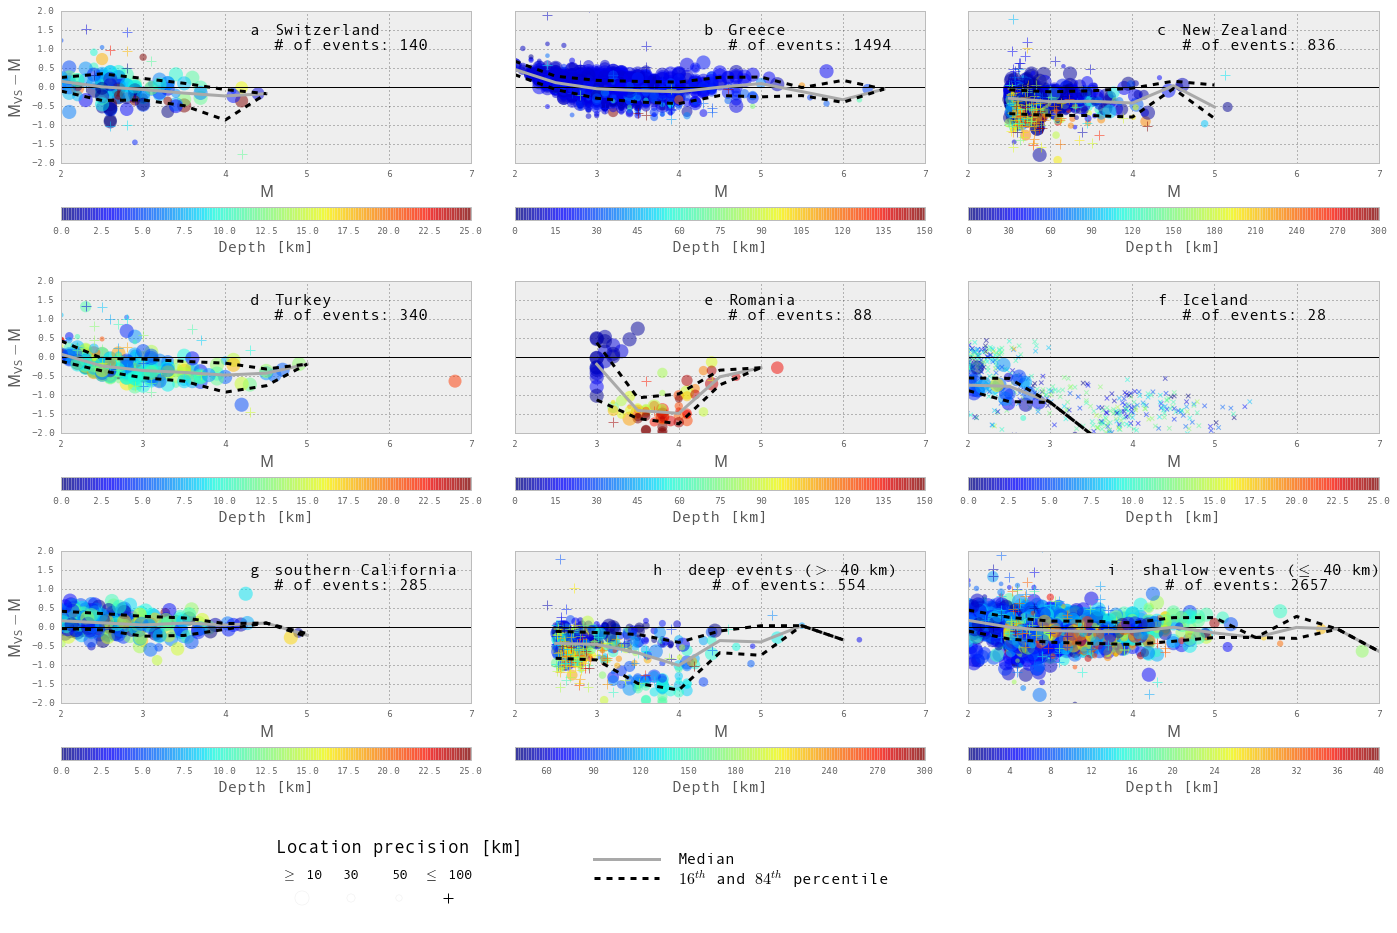

In [7]:
from magnitude_comparison import MagComp
mc = MagComp()
mc.setup()
mc.plot()

__Figure 2__. Comparison between M$_{VS}$ and M, showing sensitivity to local network magnitude, location precision, and event depth for seismicity detected across the seven seismic networks as indicated in the legends in (a)–(g). (Note that the depth scale varies between
subfigures.) The location precision is defined as the difference between scautoloc’s first hypocenter estimate and the final catalog hypocenter. The entire dataset is summarized in terms of deep and shallow events in (h) and (g), respectively. The median (solid gray line) and the 16th and 84th percentile (black dashed lines) are indicated in each figure. Location precision is determined as the difference
in kilometers between the first EEW location (used to estimate M$_{VS}$) and final network location. For shallow events in the majority of networks, M$_{VS}$ is consistent with M, though in Turkey and Iceland M$_{VS}$ appears to systematically underestimate M. For deep events from Greece, Romania, and New Zealand, M$_{VS}$ tends to underestimate the magnitude. M$_{VS}$ performs poorly in Iceland, though during the testing period, seismicity in Iceland was dominated by volcanic events during the recent Bárðarbunga volcano eruption; these very-low-frequency events are indicated by crosses in (f).

##### Alert Times

The time taken to deliver the first EEWalert is a crucial feature of any EEW system. One essential component here is an EEW algorithm that produces, for example, location and magnitude estimates using a defined minimal number of stations and record lengths. The other critical factors for fast EEW alerts are seismic network geometry and density, and the speed and reliability of data communications (Behr et al., 2015). The theoretical and observed performance for VS(SC3) at each network is summarized in Figure 3. Figure 3a presents the network density in the form of the time taken for P waves from a shallow event occurring in the region of interest to reach six stations (the minimum required for theVS(SC3) configuration used in this study). Figure 3b presents the observed real-time performance, showing the delay in providing first EEW alerts for the seismicity observed by each seismic network. Figure 3b shows that in most networks (with the exception of California and Switzerland), even in areas with high station density (P- wave travel time to the first six stations $\le$5 s; Fig. 3a), the first alerts are usually not issued until another 5 s after the P wave should have reached the sixth station and, in many cases, even significantly later. Because all networks use SC3 configurations optimized for EEW and the same EEW algorithm, these addi- tional delays reflect the data communication between the seismic sensors and the processing hub. This is illustrated in Figure 4, which shows the distribution of pick delays for each network (i.e., the time that has passed between the actual arrival of the P wave at a station and the detection of the phase using an STA/LTA detector at the processing hub). The steeper the cumulative distribution functions in Figure 4, the more capable are the respective network data communication strategies for EEW. For many of the networks included in this test, on average less than 25% of all pick detections are made within 5 s. A target for EEW should be 90% within 2 s, a performance only southern California is close to reaching.

We note that SC3’s standard location module (scautoloc) focuses on robustness rather than speed, and therefore more timely alerts may be provided with an algorithm capable of making first location estimates with very few P-wave detections. Behr et al. (2015) showed, however, that this would only lead to significantly improved alert times in parts of a seismic network with low station density. Because faster location estimates have generally larger uncertainties, the most robust way to improve alert times is to improve the seismic network. 

These delayed alert times result in a no-warning zone (the radius of the circular region around the epicenter that will not receive alerts in advance of the strong shaking as defined by the arrival of the S wave) that is typically greater than 50 km. Events with magnitudes $\ge$6.6 will cause strong shaking outside such a no-warning zone, following the relation between magnitude, source-to-site distance, and intensity by Allen et al. (2012) (which is the “positive EEW zone” after Picozzi et al. [2015] but assuming modified Mercalli intensity I$_{MM}$ = VI instead of I$_{MM}$ = VII) and therefore allow a useful, albeit short, warning. This is, of course, only a first-order approximation because finite-rupture extent, rupture complexity, and site and path effects are likely to produce laterally varying groundmotion intensities.

The delays currently observed in creating first EEW alerts at many seismic networks are significant, as we see in Figure 3b. Because a wide number of observations associated with each event, such as phase detections, location, and magnitude estimates, are stored in the SC3 database with the timestamp of its creation, the database serves as a precise, chronological log for every event detection. This not only allows measurement of time delays for single components of the real-time system (Behr et al., 2015), but can also be used to analyze if and when a particular station contributed to an earthquake detection. For Switzerland, we found that only in very few cases are P-wave detections missed by the closest stations for magnitudes $\ge$2.5. In fact, high-quality permanent seismic stations from both strong-motion and broadband sensors have noise levels low enough to detect P-wave arrivals of earthquakes that may be felt and for which earthquake alerts are relevant (M $\ge$3.5; Clinton and Heaton, 2002; Cauzzi and Clinton, 2013). We, therefore, conclude that station sensitivity is not a significant factor in delayed EEW alerts, even in the case of the smaller magnitudes. Assuming ideal (i.e., state-of-the-art) data communication delays similar to those seen for southern California (Fig. 4) and an EEW algorithm capable of predicting ground-motion levels based on two P-wave detections only, we estimated the maximum possible earthquake alerts. This was done using the approach of Behr et al. (2015), who applied a Monte Carlo simulation to the distributions of observed system delays to compute expected alert times. Figure 3c shows that for such a configuration, alerts could be sent to areas expecting very strong shaking even for moderate-sized earthquakes with magnitudes $\ge$5.0. Although estimating magnitude and location of an earthquake from the very first P-wave recordings at only two sensors generally comes with larger estimate uncertainties, several algorithms have already demonstrated its feasibility (e.g., Cua, 2005; Satriano et al., 2008; Böse et al., 2009; Kuyuk et al., 2014; Meier et al., 2015).

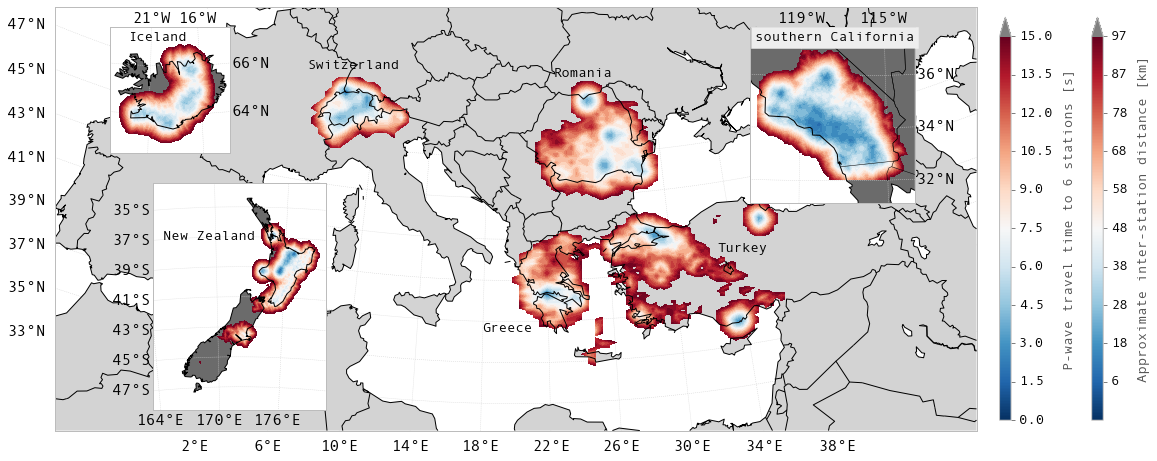

In [8]:
from overview_maps_reakt import main as delaymap
delaymap(traveltime=True)

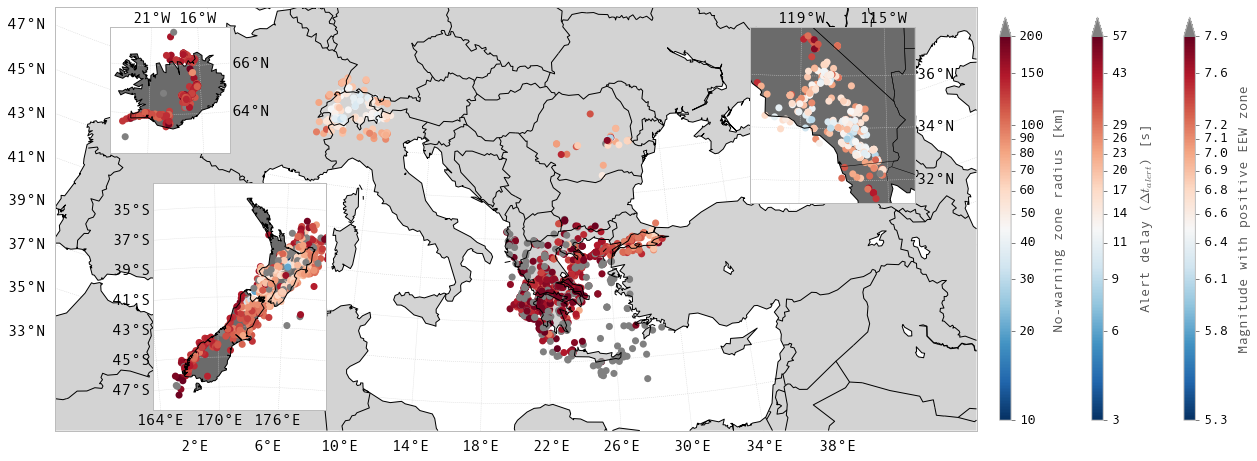

In [9]:
delaymap(blindzone=True)

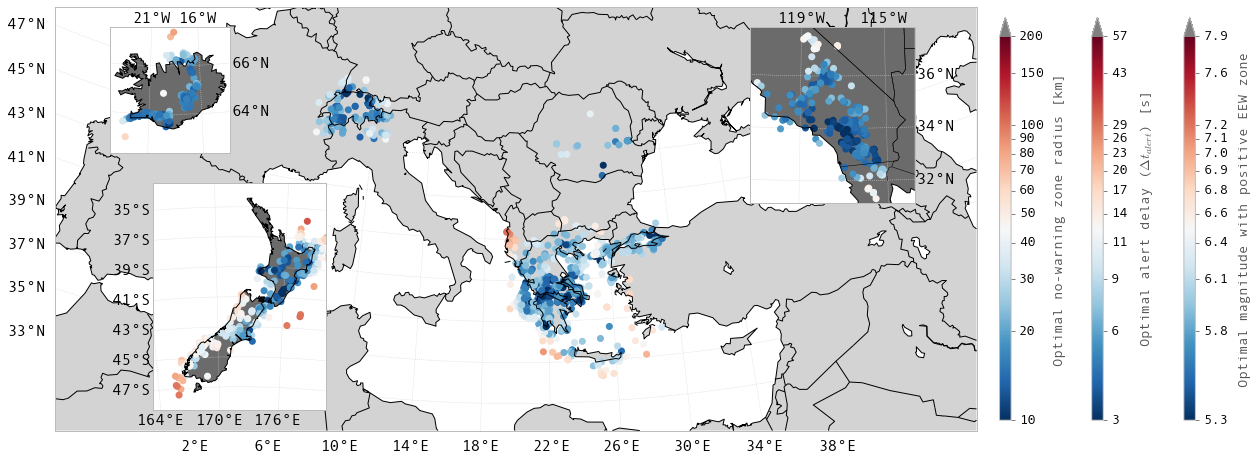

In [10]:
delaymap(optimalbz=True)

__Figure 3__.  Analysis of first EEW alert times in the seven networks. Colors in (a) indicate the theoretical P-wave travel time from any point within the maps to the closest six seismic stations, assuming a depth of 8 km and a constant P-wave velocity of 6.5 km/s. This time defines the fastest possible alerts for a six-station EEW algorithm given the network configuration, assuming negligible delays due to data transfer and processing. It also serves as a proxy for station density. (b) Observed VS(SC3) performance: — each circle is an event, with the color showing the radius of the no-warning zone, which is linearly related to the delay time for the first alert ($\Delta$t alert in Behr et al., 2015) if event depth is neglected. The size of the no-warning zone can also be used to define the magnitude required to produce a positive EEW zone, the area that will receive an alert before the onset of strong ground shaking (I$_{MM}$ $\ge$ VI). (c) The same events are shown as in (b) but for the potentially improved performance for an EEW system operating on the same network where data latencies are optimal and only two P-wave detections are required for the first source estimates.

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


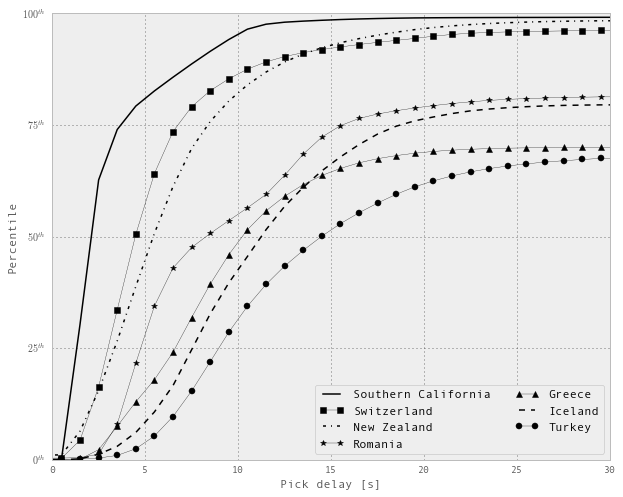

In [2]:
from delay_cdfs import main as delay_cdfs
delay_cdfs()

__Figure 4__. Cumulative distribution functions for pick delays measured for each network as the time between the detection of the P-wave arrival at the processing hub and the recording of the corresponding waveform data at the datalogger.

#### Discussion and Conclusion

<a id="discussion" ></a>
VS(SC3) is the first EEW algorithm that has become part of an open-source real-time monitoring software. This is an important aspect for enabling seismic network operators to explore and evaluate EEW with very little extra investment. Combined with low-cost sensor networks such as the Community Seismic Network (Clayton et al., 2015) or the Quake-Catcher project (Cochran et al., 2009) or with crowdsourcing networks by utilizing the accelerometer and GPS sensors in smartphones (Minson et al., 2015), such an approach may even help in bringing EEW to earthquake-prone countries that cannot afford dense, high-quality seismic networks (compare with Wu et al., 2013). 

We present results from seven networks that, for regions with similar shallow crustal seismicity, show VS(SC3) can produce early magnitude estimates that are consistent with network magnitudes. Challenges with deep seismicity exist but are not unexpected. More crucially, we demonstrate that running VS(SC3) software can highlight existing technical limitations that even the selected high-quality seismic networks (in terms of network density and standard of equipment) may face for operating EEW in general. We show that many networks provide EEW alerts with significant delays that are produced by data acquisition and communications strategies not optimized for EEW.

For the regions we studied, we have shown that relevant earthquake alerts for the existing network densities would be possible for areas of strong ground shaking, even for moderate size events, if data transfer delays were optimized and if earthquake source parameter estimates started with the first two P- wave detections. While the former depends on one-time investment into network infrastructure, building EEW algorithms that provide accurate, reliable, and robust alerts starting from only a few stations continues to be an active research area. Several algorithms already exist that can, in theory, start estimating the magnitude and epicenter from the first one or two P-wave detections. Those operating in real-time environments, however, often struggle with spurious signals and either require a certain number of seconds of waveform data or more than the minimum number of P-wave detections to achieve an acceptable number of false alerts. Employing algorithms that start estimating source parameters with the second or even the first P-wave detection therefore hinges on the ability to distinguish quickly and accurately between true and false detections. This requires extracting the maximum amount of information from the available seismic observations with accurate uncertainty estimates by, for example, identifying phase arrival times and phase types (e.g., P- and S-wave detection algorithms; Allen, 1978; Diehl et al., 2009), analyzing time–frequency characteristics of waveforms (e.g., the Gutenberg algorithm; Meier et al., 2015), characterizing spatial patterns of waveform amplitudes (e.g., FinDer; Böse et al., 2012) and phase detections (e.g., Satriano et al., 2008), or waveform polarization (e.g., LocSAT; Bratt and Bache, 1988). Characterizing and combining these elements in a fully probabilistic way allows source parameter assessments to evolve consistently from the very first estimates to a final earthquake characterization. A probabilistic approach to EEW was proposed by Cua (2005) and Cua and Heaton (2007), who demonstrated the use of Bayesian statistics for fast estimates of magnitude and epicenter, but this approach has never been implemented to work in real time. SC3’s sophisticated and extensible data model, together with its modular approach and an easy to use API, make it well suited as the implementation platform for such a probabilistic EEW/earthquake detection system. Our future efforts will be directed toward a stepwise realization of elements of this system and testing it in real time in as many of the networks running SC3 as possible.

#### DATA AND RESOURCES

<a id="resources" ></a>

The databases used to evaluate VS(SC3)’s performance are not publicly accessible, but database contents can be provided upon request. The VS(SC3) source code is open source and available as part of the SC3 software suite under https://github.com/ SeisComP3/seiscomp3. SC3 is available at https://github.com/SeisComP3/seiscomp3 or http://www.seiscomp3.org, with professional software support from gempa GmbH (http://www.gempa.de). SC3 uses Spread as the TCP/IP messaging system (http://www.spread.org). Earthquake-Early-Warning-specific user interfaces include the UserDisplay (http://www.eew.caltech.edu/research/userdisplay.html) and the Earthquake EarlyWarning Display (EEWD, https://github.com/SED-EEW/EEWD). Messages between VS(SC3) and the user interfaces are handled by an ActiveMQ broker (http://activemq.apache.org) and, incase ofthe EEWD, are following the QuakeML standard (http://www.quakeml.org). The International Federation of Digital Seismograph Networks (FDSN) web services are accessible through http://www.fdsn.org/webservices; VS(SC3)’s standard documentation is available from http://www.seiscomp3.org/doc/jakarta/current/apps/vs.html; and VS(SC3)’s quality check information is found at http://www.seiscomp3.org/doc/jakarta/current/apps/scvsmag.html#computing-the-likelihood-value. All figures for this manuscript were produced using ObsPy (Beyreuther et al., 2010)and the Matplotlib library (Hunter, 2007). All websites were last accessed on October 2015.

#### Acknowledgements

We thank Editor, Renate Hartog and two anonymous reviewers for their detailed and constructive comments, which helped to improve this article. Funding for this work came from the European Commission Seventh Framework Programme projects “Strategies and Tools for Real Time EArthquake RisK Reduction” (REAKT) and “Network of European Research Infrastructures for Earthquake Risk Assessment and Mitigation” (NERA). The Gordon and Betty Moore Foundation provided funding for the Caltech effort.

#### References

Allen, R. M., and H. Kanamori (2003). The potential for earthquake early warning in southern California, Science 300, no. 5620, 786– 789.

Allen, R. V. (1978). Automatic earthquake recognition and timing from single traces, Bull. Seismol. Soc. Am. 68, no. 5, 1521–1532.

Allen, T. I., D. J. Wald, and C. B.Worden (2012). Intensity attenuation for active crustal regions, J. Seismol. 16, no.3,409–433, doi: 10.1007/ s10950-012-9278-7.

Anderson, H., and T. Webb (1994). New Zealand seismicity: Patterns revealed by the upgraded National Seismograph Network, New Zeal. J. Geol. Geophys. 37, no.4,477–493, doi: 10.1080/ 00288306.1994.9514633.

Baer, M., and U. Kradolfer (1987). An automatic phase picker for local and teleseismic events, Bull. Seismol. Soc. Am. 77, no. 4, 1437–1445.

Behr, Y., J. Clinton, P. Kästli, C. Cauzzi, and M.-A. Meier (2015). Anatomy of an earthquake early warning (EEW) alert: Predicting time delays for an end-to-end EEW system, Seismol. Res. Lett. 86, no. 3, 830–840, doi: 10.1785/0220140179.

Beyreuther, M., R. Barsch, L. Krischer, T. Megies, Y. Behr, and J.Wassermann (2010). ObsPy: A Python Toolbox for Seismology, Seismol. Res. Lett. 81, no. 3, 530–533, doi: 10.1785/gssrl.81.3.530.

Böse, M., E. Hauksson, K. Solanki, H. Kanamori, and T. H. Heaton (2009). Real-time testing of the on-site warning algorithm in southern
California and its performance during the July 29 2008 Mw 5.4 Chino Hills earthquake, Geophys. Res. Lett. 36, no.3,2–6, doi: 10.1029/ 2008GL036366.

Böse, M., T. H. Heaton, and E. Hauksson (2012). Real-time finite fault rupture detector (FinDer) for large earthquakes, Geophys. J. Int. 191, no. 2, 803–812, doi: 10.1111/j.1365-246X.2012.05657.x.

Böse, M., R. Allen, H. Brown, G. Cua, M. Fischer, E. Hauksson, T. Heaton, M. Hellweg, M. Liukis, D. Neuhauser, et al. (2013). CISN ShakeAlert—An earthquake early warning demonstration system for California, in Early Warning for Geological Disasters—Scientific Methods and Current Practice, 
F. Wenzel and J. Zschau (Editors), Springer, Heidelberg, Germany.

Bratt, S. R., and T. C. Bache (1988). Locating events with a sparse network of regional arrays, Bull. Seismol. Soc. Am. 78, no. 2, 780–798.

Cauzzi, C., and J. F. Clinton (2013). A high- and low-noise model for high-quality strong-motion accelerometer stations, Earthq. Spectra 29, no. 1, 85–102, doi: 10.1193/1.4000107.

Chen, D.-Y., N.-C. Hsiao, and Y.-M. Wu (2015). The Earthworm based earthquake alarm reporting system in Taiwan, Bull. Seismol. Soc. Am. 105, no. 2A, 568–579, doi: 10.1785/0120140147.

Clayton, R. W., T. Heaton, M. Kohler, M. Chandy, R. Guy, and J. Bunn (2015). Community seismic network: A dense array to sense earthquake strong motion, Seismol. Res. Lett. 86, no. 5, 1354–1363, doi: 10.1785/0220150094.

Clinton, J. F., and T. H. Heaton (2002). Potential advantages of a strong-motion velocity meter over a strong-motion accelerometer, Seismol. Res. Lett. 73, no. 3, 332–342.

Cochran, E. S., J. F. Lawrence, C. Christensen, and R. S. Jakka (2009). The Quake-Catcher Network: Citizen science expanding seismic horizons, Seismol. Res. Lett. 80, no. 1, 26–30, doi: 10.1785/ gssrl.80.1.26.

Colombelli, S., A. Caruso, A. Zollo, G. Festa, and H. Kanamori (2015). A P-wave-based, on-site method for earthquake early warning, Geophys. Res. Lett. 42, no. 5, 1390–1398, doi: 10.1002/2014GL063002.

Cooper, J. D. (1868). Earthquake indicator, San Francisco Daily Bulletin, 3 November.

Cua, G. B. (2005). Creating the Virtual Seismologist: Developments in Ground Motion Characterization and Seismic Early Warning, Ph.D. Thesis, California Institute of Technology.

Cua, G. B., and T. H. Heaton (2007). The Virtual Seismologist (VS) method: A Bayesian approach to earthquake early warning, in Earthquake Early Warning Systems, P. Gasparini, G. Manfredi, and J. Zschau (Editors), Springer-Verlag, Berlin, Germany, 97–130.

Cua, G. B., M. Fischer, T. H. Heaton, and S. Wiemer (2009). Real-time performance of the Virtual Seismologist earthquake early warning algorithm in southern California, Seismol. Res. Lett. 80, no. 5, 740–747, doi: 10.1785/gssrl.80.5.740.

Delavaud, E., F. Cotton, S. Akkar, F. Scherbaum, L. Danciu, C. Beauval, S. Drouet, J. Douglas, R. Basili, M. Sandikkaya, et al. (2012). Toward a ground-motion logic tree for probabilistic seismic hazard assessment in Europe, J. Seismol. 16, no. 3, 451–473, doi: 10.1007/s10950-012- 9281-z.

Diehl, T., N. Deichmann, E. Kissling, and S. Husen (2009). Automatic S-wave picker for local earthquake tomography, Bull. Seismol. Soc. Am. 99, no. 3, 1906–1920, doi: 10.1785/0120080019.

Diehl, T., J. Clinton, T.Kraft, S.Husen, K. Plenkers, A. Guilhelm, Y. Behr, C. Cauzzi, P. Kästli, F. Haslinger, et al. (2014). Earthquakes in Switzerland and surrounding regions during 2013, Swiss J. Geosci. 107, no. 2, 359–375, doi: 10.1007/s00015-014-0171-y.

Espinosa-Aranda, J. M., A. Jimenez,G. Ibarrola, F. Alcantar, A. Aguilar, M. Inostroza, and S. Maldonado (1995). Mexico City seismic alert system, Seismol. Res. Lett. 66, no.6,42–53, doi: 10.1785/gssrl.66.6.42.

Giardini, D., G. Grünthal, K. M. Shedlock, and P. Zhang (1999). The GSHAP global seismic hazard map, Ann. Geofis. 42, no.6,1225– 1230, doi: 10.4401/ag-3784.

Giardini, D., J. Wössner, and L. Danciu (2014). Mapping Europe’s seismic hazard, Eos Trans AGU 95, no. 29, 261–262, doi: 10.1002/ 2014EO290001.

Hanka, W., A. Heinloo, and K. Jaeckel (2000). Networked seismographs: GEOFON real-time data distribution, ORFEUS Newsletter, Vol. 2,
no. 3, http://www.orfeus‑eu.org/organization/Organization/Newsletter/vol2no3/geofon.html (last accessed February 2016).

Hanka, W., J. Saul, B.Weber, J. Becker, and P. Harjadi (2010). Real-time earthquake monitoring for tsunami warning in the Indian Ocean and beyond, Nat. Hazards Earth Syst. Sci. 10, no. 12, 2611–2622, doi: 10.5194/nhess-10-2611-2010.

Hauksson, E. (2010). Spatial separation of large earthquakes, aftershocks, and background seismicity: Analysis of interseismic and coseismic seismicity patterns in southern California, Pure Appl. Geophys. 167, nos. 8/9, 979–997, doi: 10.1007/s00024-010-0083-3.

Heaton, T. H. (1985). A model for a seismic computerized alert network, Science 228, 987–990.

Hoshiba, M., and S. Aoki (2015). Numerical shake prediction for earthquake early warning: Data assimilation, real-time shake mapping, and simulation of wave propagation, Bull. Seismol. Soc. Am. 105, no. 3, 1324–1338, doi: 10.1785/0120140280.

Hoshiba, M., O. Kamigaichi, M. Saito, S. Tsukada, and N. Hamada (2008). Earthquake early warning starts nationwide in Japan, Eos Trans. AGU 89, no. 8, 73–74, doi: 10.1029/2008EO080001.

Hunter, J. D. (2007). Matplotlib: A 2D graphics environment, Comput. Sci. Eng. 9, no. 3, 90–95, doi: 10.1109/MCSE.2007.55.

Kanamori, H. (1993). Locating earthquakes with amplitude: Application to real-time seismology, Bull. Seismol. Soc. Am. 83, no. 1, 264–268.

Kastrup, U., M. L. Zoback, N.Deichmann, K. F. Evans, D. Giardini, and A. J. Michael (2004). Stress field variations in the Swiss Alps and the northern Alpine foreland derived from inversion of fault plane solutions, J. Geophys. Res. 109, no. B1, 1–22, doi: 10.1029/ 2003JB002550.

Kuyuk, H. S., R. M. Allen, H. M. Brown, M. Hellweg, I. Henson, and D. Neuhauser (2014). Designing a network-based earthquake early warning algorithm for California: ElarmS-2, Bull. Seismol. Soc. Am. 104, no. 1, 162–173, doi: 10.1785/0120130146.

Mărmureanu, A., C. Ionescu, and C. O. Cioflan (2011). Advanced real-time acquisition of the Vrancea earthquake early warning system, Soil Dynam. Earthq. Eng. 31, no. 2, 163–169, doi: 10.1016/j.soil- dyn.2010.10.002.

Meier, M.-A., T. Heaton, and J. Clinton (2015). The Gutenberg algorithm: Evolutionary Bayesian magnitude estimates for earthquake early warning with a filter bank, Bull. Seismol. Soc. Am. 105, no. 5, 2774–2786, doi: 10.1785/0120150098.

Minson, S. E., B. Brooks, C. L. Glennie, J. R. Murray, J.O. Langbein, S. E. Owen, T. H. Heaton, R. A. Iannucci, and D. L. Hauser (2015). Crowdsourced earthquake early warning, Sci. Adv. 1, no. 3, 1–7, doi: 10.1126/sciadv.1500036.

Nakamura, Y. (1988). On the Urgent Earthquake Detection, and Alarm System (UrEDAS), Proc. of Ninth World Conference on Earthquake Engineering, Tokyo-Kyoto, Japan, 2–9 August 1988.

Peng, H., Z. Wu, Y.-M. Wu, S. Yu, D. Zhang, and W. Huang (2011). Developing a prototype earthquake early warning system in the Beijing capital region, Seismol. Res. Lett. 82, no. 3, 394–403, doi: 10.1785/gssrl.82.3.394.

Picozzi, M., A. Zollo, P. Brondi, S. Colombelli, L. Elia, and C. Martino (2015). Exploring the feasibility of a nation-wide earthquake early warning system in Italy, J. Geophys. Res. 120, no. 4, 2446–2465, doi: 10.1002/2014JB011669.

Satriano, C., A. Lomax, and A. Zollo (2008). Real-time evolutionary earthquake location for seismic early warning, Bull. Seismol. Soc. Am. 98, no. 3, 1482–1494, doi: 10.1785/0120060159.

Sigmundsson, F., A. Hooper, S. Hreinsdóttir, K. Vogfjörd, B. Ófeigsson, E. Heimisson, S. Dumont, M. Parks, K. Spaans, G. Gudmundsson, et al. (2015). Segmented lateral dyke growth in a rifting event at Bárðarbunga volcanic system, Iceland, Nature 517, no. 7533, 191–195, doi: 10.1038/nature14111.

Stirling, M., G. McVerry, M. Gerstenberger, N. Litchfield, R. Van Dissen, K. Berryman, P. Barnes, L.Wallace, P. Villamor, R. Langridge, et al. (2012). National seismic hazard model for New Zealand: 2010 update, Bull. Seismol. Soc. Am. 102, no. 4, 1514–1542, doi: 10.1785/ 0120110170.

Tamaribuchi, K., M. Yamada, and S. Wu (2014). A new approach to identify multiple concurrent events for improvement of earthquake early warning, Zisin 67, no. 2, 41–55.

Wu, Y.-M., D.-Y. Chen, T.-L. Lin, C.-Y. Hsieh, T.-L. Chin, W.-Y. Chang, W.-S. Li,and S.-H. Ker (2013). A high-density seismic network for earthquake early warning in Taiwan based on low cost sensors, Seismol. Res. Lett. 84, no. 6, 1048–1054, doi: 10.1785/ 0220130085.

Zollo, A., S. Colombelli, L. Elia, A. Emolo, G. Festa, G. Iannaccone, C. Martino, and P. Gasparini (2013). An integrated regional, and on-site earthquake early warning system for southern Italy: Concepts, methodologies, and performances, in Early Warning for Geological Disasters—Scientific Methods and Current Practice, J. Z. Friedemann Wenzel (Editor), Springer, Heidelberg, Germany, 117–138.

#### Electronic supplement

<a id="supplement"></a>

In this supplementary material we show a comparison of the GMPE, that is part of the VS likelihood function, with two other GMPEs, representative for the regions discussed in this study.

The predictive equations for P- and S-wave amplitude in the VS likelihood function are mostly based on (and therefore representative of) the seismicity of southern California, although Figure 2 shows that M$_{VS}$ is suitable also for other test regions in Europe and worldwide, with the exception of deep seismicity and the volcanic earthquakes in Iceland. Possible explanations of this behaviour are shown in Figure S1, where the magnitude scaling (top panel) and distance dependence (bottom panel) of the horizontal peak ground motions predicted by VS are compared to the models of Akkar et al. (2014) and Bradley (2013), representative of Pan-European and New Zealand active shallow crustal seismicity, respectively. Apparent from Figure S1, the median magnitude scaling of Akkar et al. (2014) and Bradley (2013) always falls within the 1$\sigma$ bound of the VS prediction, the model of Akkar et al. (2014) being closer to the median VS model. That is, the models shown in the top panel of Figure S1 are statistically equivalent with 68% confidence. Similar conclusions are valid for the distance dependence at high (M$_W$ 7) magnitudes, where the predictive tool by Akkar et al. (2014) shows a remarkable agreement with VS for R$_{JB}$ (Joyner and Boore, 1981) distances smaller than 10 km. At lower magnitudes (e.g., M$_W$ 7), the predictions of Akkar et al. (2014) and Bradley (2013) are closer to the 84-percentile levels of the VS predictions. These observations are consistent with recent approaches in developing global ground motion prediction models for homogeneous seismotectonic settings (e.g., Gregor et al., 2014; Cauzzi et al., 2014) where significant regional dependence of strong ground motions (if modeled at all) is typically associated with anelastic attenuation terms (Boore et al., 2014) and therefore becomes apparent only at very large distances from the earthquake source. The bottom panel of Figure S1 seems to suggest that the VS equations will perform better at higher magnitudes thus enhancing the soundness of the predictive tool for potentially damaging events. 

##### References

Akkar S, Sandıkkaya MA, Bommer JJ (2014) Empirical ground-motion models for point- and extended-source crustal earthquake scenarios in Europe and the Middle East. Bull Earthq Eng 12:359–387. doi: 10.1007/s10518-013-9461-4

Bradley BA (2013) A New Zealand-Specific Pseudospectral Acceleration Ground-Motion Prediction Equation for Active Shallow Crustal Earthquakes Based on Foreign Models. Bull Seismol Soc Am 103:1801–1822. doi: 10.1785/0120120021

Boore DM, Stewart JP, Seyhan E, Atkinson GM (2014) NGA-West 2 Equations for Predicting PGA, PGV, and 5%-Damped PSA for Shallow Crustal Earthquakes. Earthq Spectra 131108093828003. doi: 10.1193/070113EQS184M

Cauzzi C, Faccioli E, Vanini M, Bianchini A (2014) Updated predictive equations for broadband (0.01–10 s) horizontal response spectra and peak ground motions, based on a global dataset of digital acceleration records. Bull Earthq Eng. doi: 10.1007/s10518-014-9685-y

Gregor N, Abrahamson NA, Atkinson GM, et al. (2014) Comparison of NGA-West2 GMPEs. Earthq Spectra 140210104921003. doi: 10.1193/070113EQS186M
JOYNER WB, BOORE DM (1981) Peak horizontal acceleration and velocity from strong-motion records including records from the 1979 imperial valley, California, earthquake. Bull Seismol Soc Am 71:2011–2038.

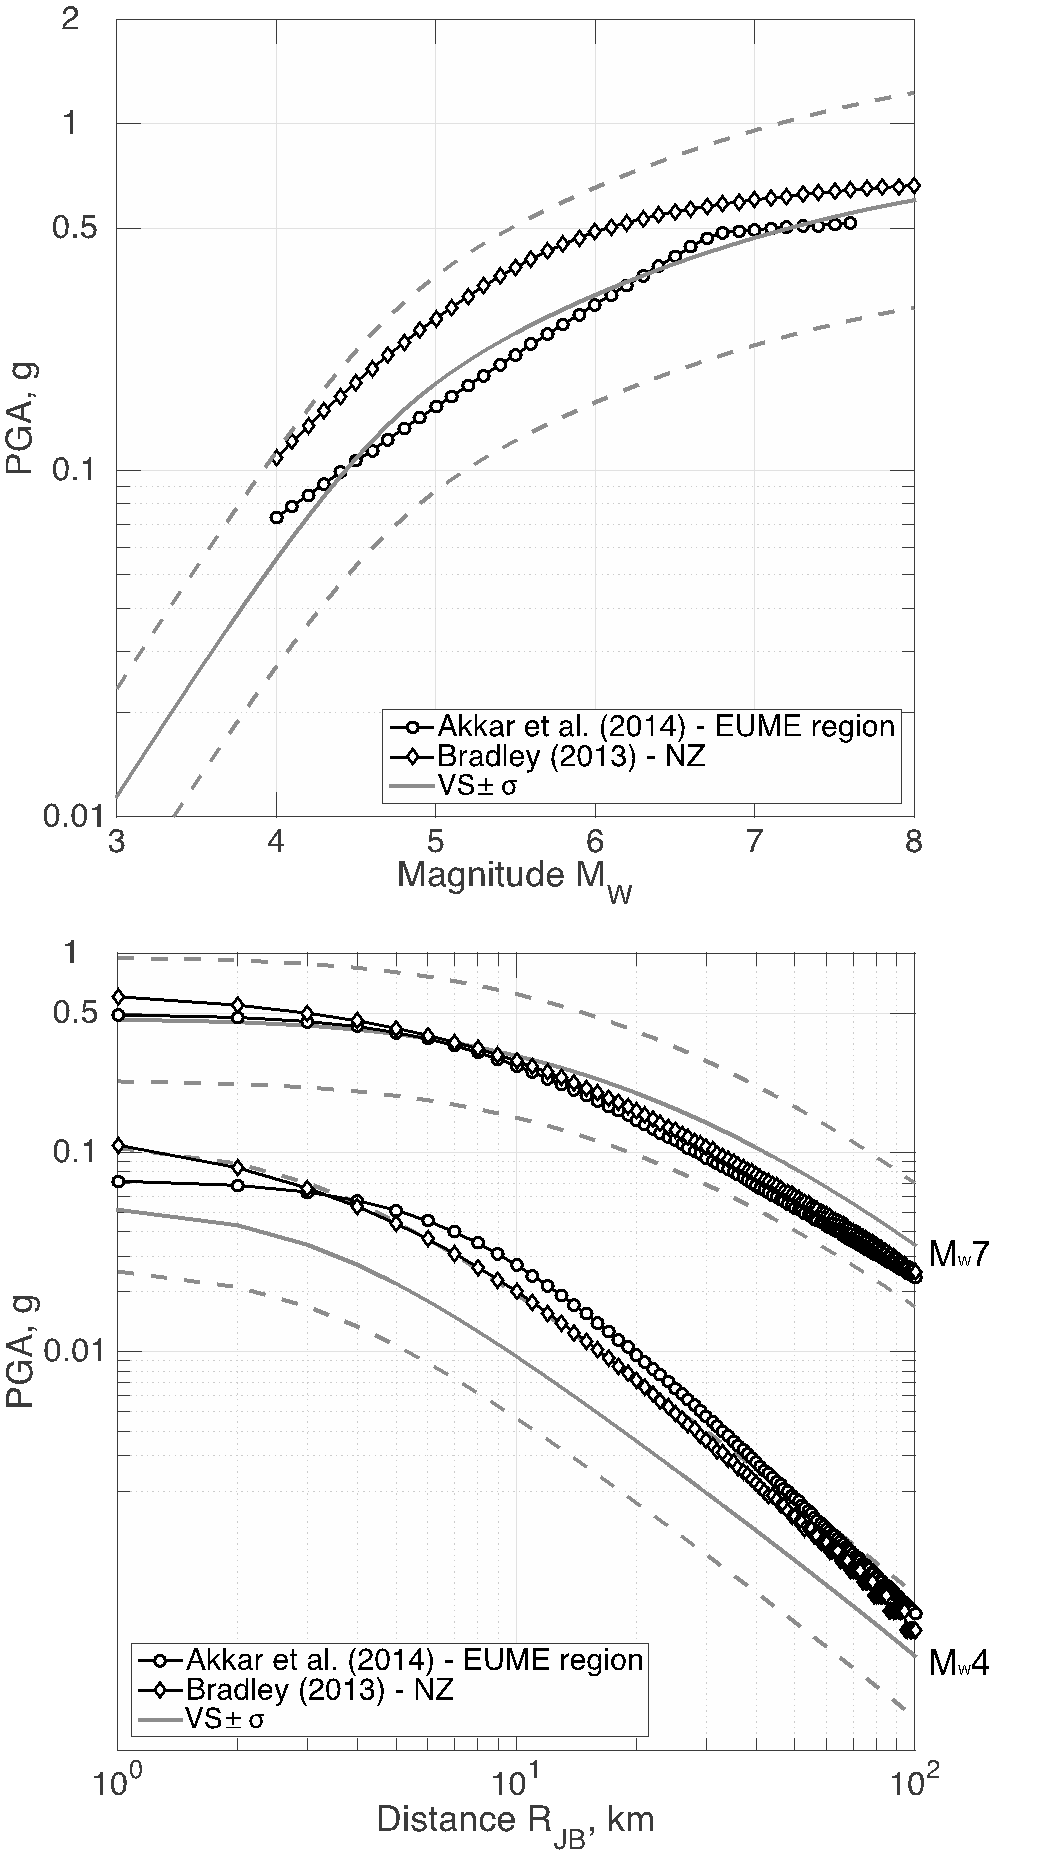

In [5]:
Image(filename='plots/GMPE_comparison.png')

__Figure S1__. Comparison of the predictive model (16-, 50- and 84-percentile levels; the grey curves)  for horizontal peak ground motions implemented in VS with the recent European and New Zealand models by Akkar et al. (2014) and Bradley (2013), both  evaluated for strike-slip events, and V$_{S,30}$ = 760 ms$^{-1}$ (black curves with symbols). Top panel: magnitude scaling at R$_{JB}$ = 0. Bottom panel: attenuation with distance for low (M$_W$ 4) and high (M$_W$ 7)  magnitude values.

## Additional analysis

The following shows more detailed analysis for each network.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import json
from scipy.stats import scoreatpercentile
from optimal_blindzone import plot_bz
import sys

def plot_data_delays(data, fout=None, networks=['*'],
                     lineplot=False, xlabel='Pick delays [s]',
                     llabel='', xmin=None, xmax=None, ax=None,
                     color='k',cumulative=False):
    try:
        fh = open(data)
        pkdel = json.load(fh)
        fh.close()
        delays = {}
        for _k in pkdel:
            net,sta = _k.split('.')
            if net not in networks and '*' not in networks:
                continue
            if net not in delays:
                delays[net] = pkdel[_k]
            else:
                delays[net] += pkdel[_k]
    except:
        delays = data
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    if lineplot:
        all_delays = []
        for _n in delays.keys():
            all_delays += delays[_n]
        n, bins, patches = ax.hist(all_delays,bins=np.arange(0, 20,1.0),
                               histtype='step', color=color,
                               rwidth=1.0, normed=True,label=llabel,
                               cumulative=cumulative)
    else:
        n, bins, patches = ax.hist([delays[_n] for _n in delays.keys()],
                                   bins=np.arange(-30, 30,1.0),
                                   histtype='barstacked',
                                   label=[_n for _n in delays.keys()],
                                   rwidth=1.0)

        ax.set_xlabel(xlabel)
        ax.legend()
    if xmin is not None and xmax is not None:
        ax.set_xlim(xmin,xmax)
    if fout is not None:
        plt.savefig(fout, dpi=300)

def plot_origin_creation_time(fin,fout=None):
    a = np.load(fin)
    delays_ct = a['delays']
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    n, bins, patches = ax1.hist(delays_ct, bins=np.arange(-30, 30, 1.0),
                                color='blue', rwidth=1.0)
    med = np.median(delays_ct)
    percentile16 = scoreatpercentile(delays_ct, 16)
    percentile84 = scoreatpercentile(delays_ct, 84)
    ax1.text(0.6, 0.7, 'Median: %.1f s' % (med), horizontalalignment='left',
            transform=ax1.transAxes, color='blue')
    ax1.text(0.6, 0.65, '16th percentile: %.1f s' % (percentile16), horizontalalignment='left',
            transform=ax1.transAxes, color='blue')
    ax1.text(0.6, 0.6, '84th percentile: %.1f s' % (percentile84), horizontalalignment='left',
            transform=ax1.transAxes, color='blue')
    ax1.set_xlabel('Event declaration time [s]')
    if fout is not None:
        plt.savefig(fout, dpi=300)

## Turkey

### Pick delays

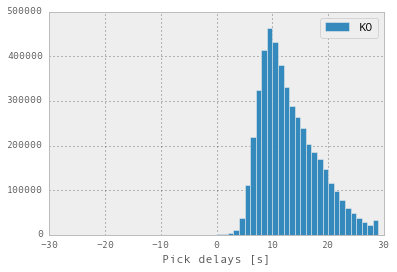

In [22]:
fin = './data/pick_delays_tr.txt'
plot_data_delays(fin,networks=['KO'])

### Origin creation time

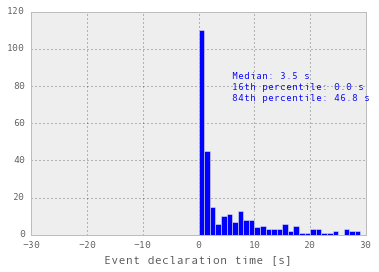

In [23]:
fin = './data/origin_creation_time_tr.npz'
plot_origin_creation_time(fin)

### Optimal blind zone

(<alerttimemap.AlertTimeMap instance at 0x7f84c0eb8b00>,
 <matplotlib.colorbar.ColorbarBase at 0x7f84c0f136d0>)

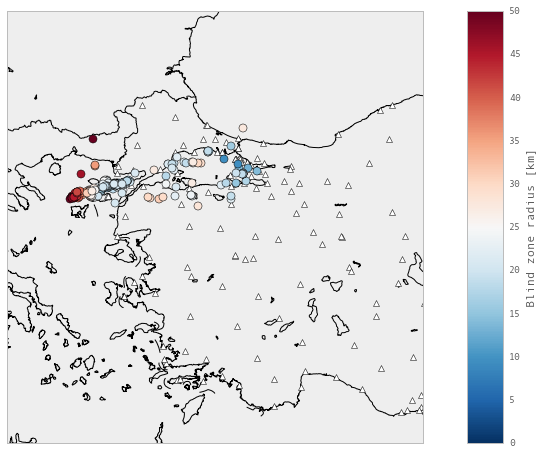

In [18]:
eventsfn = './data/event_list_tr.csv'
stationsfn = './data/stations_tr.txt'
fout = './data/optimal_blindzone_tr.npz'
plot_bz(events=eventsfn,stations=stationsfn,vmin=0,vmax=50,new=False,
        fout=fout,mapbnd=(35.5, 43.5, 23.5, 33.5, 37.5), at=False,
        bzreduction=False)

## Romania

### Pick delays

In the beginning the server running SC3 in Romania wasn't using ntp which produced negative delays (picks arrived before they were detected :-)). For the timespan chosen below, this problem seems to be solved for all except one or two networks.

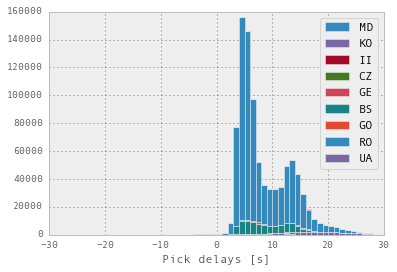

In [19]:
fin = './data/pick_delays_ro.txt'
plot_data_delays(fin)

### Envelope delays

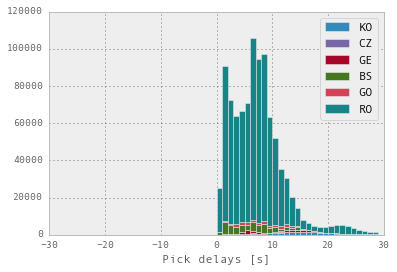

In [25]:
fin = './data/env_delays_ro.txt'
plot_data_delays(fin,llabel='Envelope delays [s]')

### Origin creation time

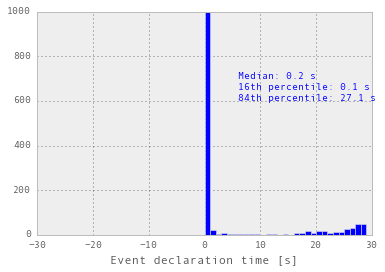

In [26]:
fin = './data/origin_creation_time_ro.npz'
plot_origin_creation_time(fin)

### Optimal blind zone

No envelope delay data available for the following stations:

No pick delay info available for the following stations:

(88,)


tt: 100% |######################################################| Time: 0:00:13


(<alerttimemap.AlertTimeMap instance at 0x7f84becf9878>,
 <matplotlib.colorbar.ColorbarBase at 0x7f84ba4799d0>)

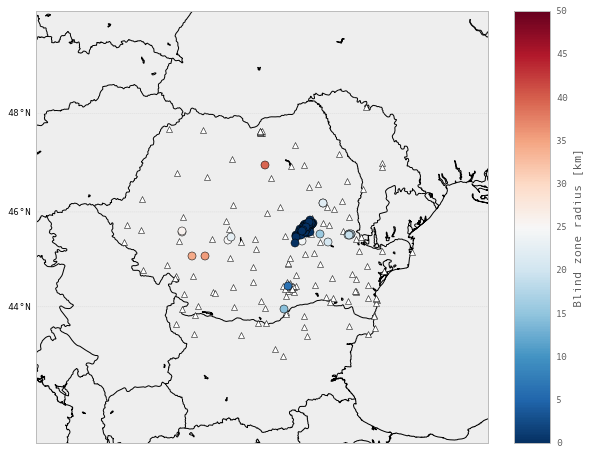

In [27]:
eventsfn = './data/event_list_ro.csv'
stationsfn = './data/stations_ro.txt'
fout = './data/optimal_blindzone_ro.npz'
plot_bz(events=eventsfn,stations=stationsfn,vmin=0,vmax=50,new=True,
        fout=fout,mapbnd=(41., 50., 18.5, 32., 45.5),at=False,
        bzreduction=False)

## Switzerland

### Pick delays

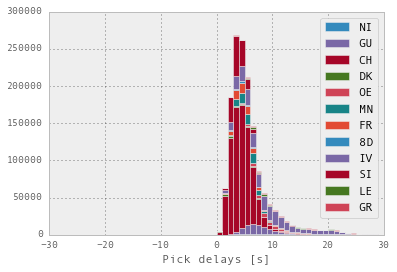

In [28]:
fin = './data/pick_delays_ch.txt'
plot_data_delays(fin)

### Envelope delays

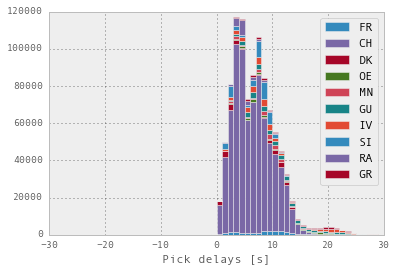

In [30]:
fin = './data/env_delays_ch.txt'
plot_data_delays(fin,llabel='Envelope delays [s]')

### Origin creation time

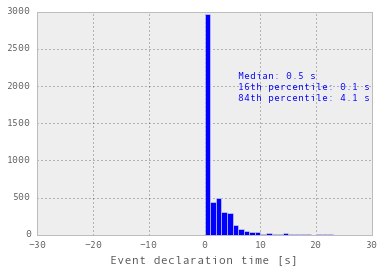

In [31]:
fin = './data/origin_creation_time_ch.npz'
plot_origin_creation_time(fin)

### Optimal blind zone

No envelope delay data available for the following stations:

No pick delay info available for the following stations:

(140,)


tt: 100% |######################################################| Time: 0:00:23


(<alerttimemap.AlertTimeMap instance at 0x7f84bdaefb00>,
 <matplotlib.colorbar.ColorbarBase at 0x7f84bdc52fd0>)

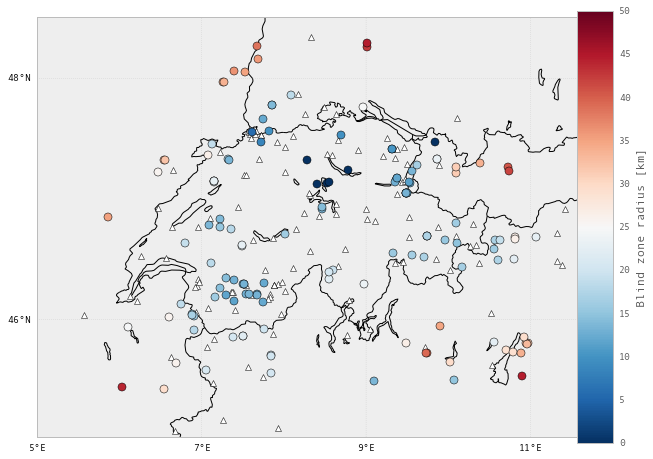

In [33]:
eventsfn = './data/event_list_ch.csv'
stationsfn = './data/stations_ch.txt'
fout = './data/optimal_blindzone_ch.npz'
plot_bz(events=eventsfn,stations=stationsfn,vmin=0,vmax=50,new=True,
        fout=fout,mapbnd=(45, 48.5, 5, 12, 47), at=False,
        bzreduction=False)

## Iceland

### Pick delays

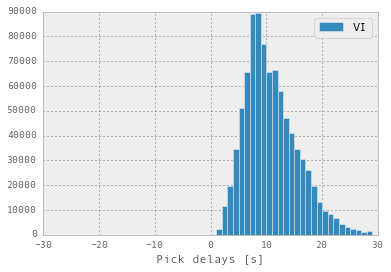

In [34]:
fin = './data/pick_delays_is.txt'
plot_data_delays(fin)

### Origin creation time

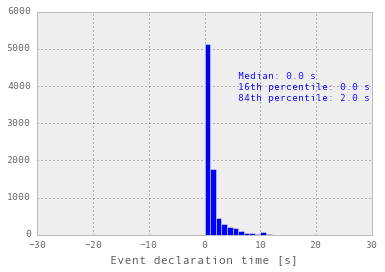

In [35]:
fin = './data/origin_creation_time_is.npz'
plot_origin_creation_time(fin,fout=None)

### Optimal blind zone

No envelope delay data available for the following stations:

No pick delay info available for the following stations:

(1521,)


(<alerttimemap.AlertTimeMap instance at 0x7f84be1405f0>,
 <matplotlib.colorbar.ColorbarBase at 0x7f84be1460d0>)

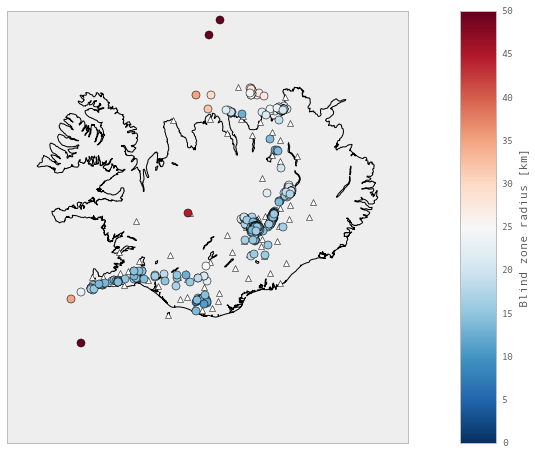

In [36]:
eventsfn = './data/event_list_iceland_all.csv'
stationsfn = './data/stations_is.txt'
fout = './data/optimal_blindzone_is.npz'
plot_bz(events=eventsfn,stations=stationsfn,vmin=0,vmax=50,new=True,
        fout=fout,mapbnd=(61.5, 67.5, -25.5, -12.5, 64.5),at=False,
        bzreduction=False)

## Greece

### Pick delays

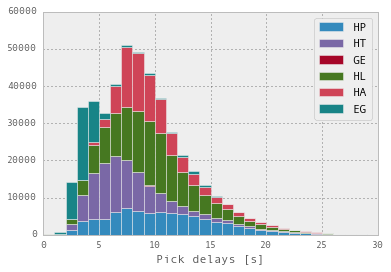

In [37]:
fin = './data/pick_delays_gr.txt'
plot_data_delays(fin,xmin=0,xmax=30)

### Envelope delays

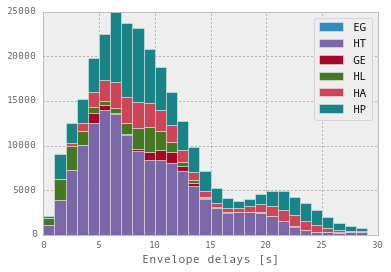

In [50]:
fin = './data/env_delays_gr.txt'
plot_data_delays(fin,xlabel='Envelope delays [s]', xmin=0,xmax=30)

### Origin creation time

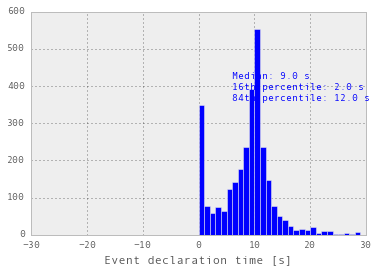

In [40]:
fin = './data/origin_creation_time_gr.npz'
plot_origin_creation_time(fin,fout=None)

### Optimal blind zone

No envelope delay data available for the following stations:

No pick delay info available for the following stations:

(1494,)


tt: 100% |######################################################| Time: 0:05:09


(<alerttimemap.AlertTimeMap instance at 0x7f84bccae710>,
 <matplotlib.colorbar.ColorbarBase at 0x7f84bcdeead0>)

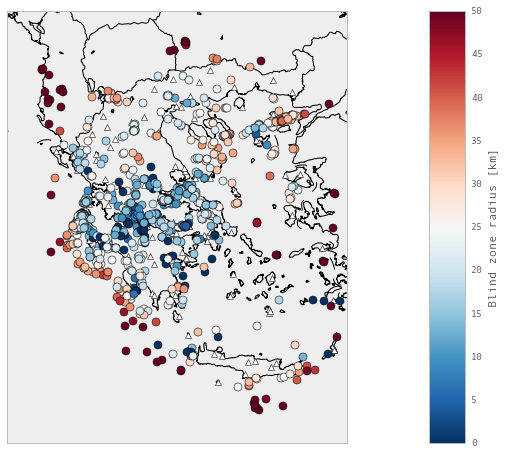

In [41]:
eventsfn = './data/event_list_gr.csv'
stationsfn = './data/stations_gr.txt'
fout = './data/optimal_blindzone_gr.npz'
plot_bz(events=eventsfn,stations=stationsfn,vmin=0,vmax=50,new=True,
        fout=fout,mapbnd=(33.5, 42.5, 18.5, 27.5, 39), at=False,
        bzreduction=False)

## New Zealand

### Pick delays

In New Zealand an autopicker is used that waits for 8 s of waveform data before producing a pick (pick method 'AIC').

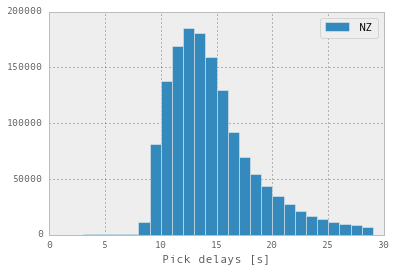

In [42]:
fin = './data/pick_delays_nz.txt'
plot_data_delays(fin, xmin=0, xmax=30)

### Envelope delays

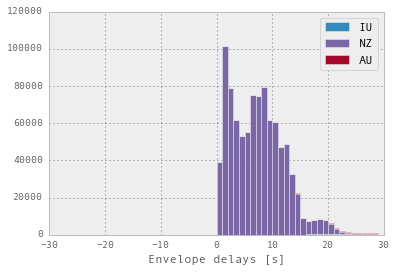

In [49]:
fin = './data/env_delays_nz.txt'
plot_data_delays(fin,xlabel='Envelope delays [s]')

### Origin creation time

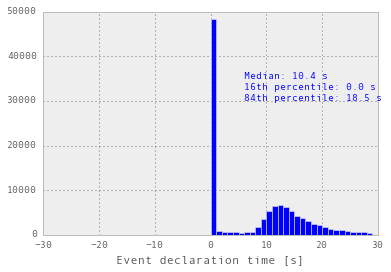

In [44]:
fin = './data/origin_creation_time_nz.npz'
plot_origin_creation_time(fin)

### Optimal blind zone

No envelope delay data available for the following stations:

No pick delay info available for the following stations:

(836,)


(<alerttimemap.AlertTimeMap instance at 0x7f84b98ec368>,
 <matplotlib.colorbar.ColorbarBase at 0x7f84b99babd0>)

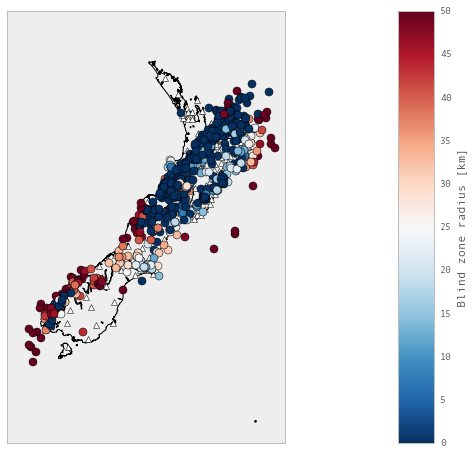

In [45]:
eventsfn = './data/event_list_nz.csv'
stationsfn = './data/stations_nz.txt'
fout = './data/optimal_blindzone_nz.npz'
plot_bz(events=eventsfn,stations=stationsfn,vmin=0,vmax=50,new=True,
        fout=fout,mapbnd=(-50.5, -32., 164.5, 180.5, -41.25), at=False,
        bzreduction=False)

## California

### Pick delays

Note: system time was not properly synchronized with ntp before 2014/11/01.

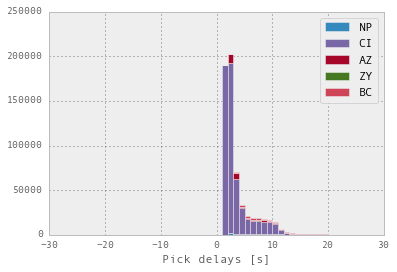

In [46]:
fin = './data/pick_delays_ca.txt'
plot_data_delays(fin)
    

### Envelope delays

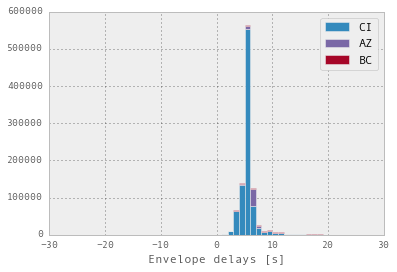

In [51]:
fin = './data/env_delays_ca.txt'
plot_data_delays(fin,xlabel='Envelope delays [s]')

### Origin creation time

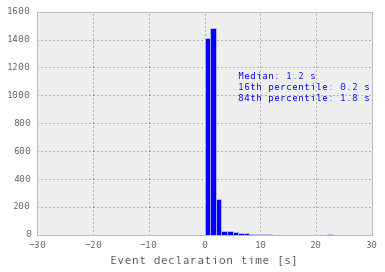

In [52]:
fin = './data/origin_creation_time_ca.npz'
plot_origin_creation_time(fin)

### Optimal blind zone

No envelope delay data available for the following stations:

No pick delay info available for the following stations:

(430,)


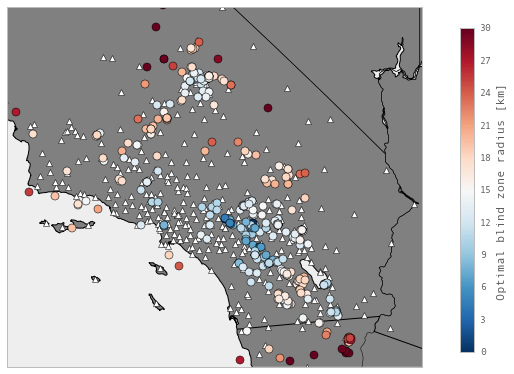

In [53]:
eventsfn = './data/event_list_ca.csv'
stationsfn = './data/stations_ca.txt'
fout = './data/optimal_blindzone_ca.npz'
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.08,0.05,0.8,0.5])
cax = fig.add_axes([0.82, 0.07, 0.02, 0.45])
am, cb = plot_bz(events=eventsfn,stations=stationsfn,vmin=0,vmax=30,new=True,
        fout=fout,mapbnd=(32, 37, -121, -114, 36),
        fig=fig,ax=ax,cax=cax,at=False, bzreduction=False)
am.m.fillcontinents('gray', zorder=0)
cb.set_label('Optimal blind zone radius [km]')
plt.show()